# Step 3.2: GitHub Log Analysis

In [1]:
import pandas as pd 
import os
import csv
import re
import json
from collections import Counter
from os import listdir
results_dir = "/home/notebooks/ProjectAnalysis/GitHubProyectsAnalysis/results/"
import matplotlib.pyplot as plt
pd.options.display.float_format = "{:,.2f}".format

In [2]:
def getSummary(project_name, commit_history):
    summary = {}
    summary['Project'] = project_name
    summary["Total"] = 0
    summary["Success"] = 0
    summary["Fail"] = 0
    
    summary['MavenSuccess'] = 0
    summary['MavenFail'] = 0
    summary['GradleSuccess'] = 0
    summary['GradleFail'] = 0
    summary['AntSuccess'] = 0
    summary['AntFail'] = 0
    summary['NoBuildSystem'] = 0
    summary['Errors'] = []
    
    
    for result in commit_history:
        
        summary["Total"] += 1
        
        if result['BUILD_STATUS'] == 'SUCCESS':
            
            summary["Success"] += 1
        
            if result['BUILD_SYSTEM'] == 'Maven':
                summary['MavenSuccess'] += 1
            if result['BUILD_SYSTEM'] == 'Gradle':
                summary['GradleSuccess'] += 1
            if result['BUILD_SYSTEM'] == 'Ant':
                summary['AntSuccess'] += 1
                
        else: # FAILED BUILDS
            
            if result['ERROR'] == 'No build system detected':
                summary['NoBuildSystem'] += 1
            
            summary["Fail"] += 1
            
            if result['BUILD_SYSTEM'] == 'Maven':
                summary['MavenFail'] += 1
            if result['BUILD_SYSTEM'] == 'Gradle':
                summary['GradleFail'] += 1
            if result['BUILD_SYSTEM'] == 'Ant':
                summary['AntFail'] += 1
#             if result['BUILD_SYSTEM'] == 'NOT_FOUND':
#                 summary['NoBuildSystem'] += 1
            
            action = result['ACTION']
            if action not in ['Resolution', 'Parsing', 'Compilation', 'Other']:
                if result['ERROR'] == 'Timeout': 
                    action = 'Resolution'
                else:
                    action = 'Other'
                
            summary['Errors'].append((result['BUILD_SYSTEM'], result['ERROR'], action))
                
    return summary

In [3]:
projects = [f for f in listdir(results_dir)]
results = {}

all_projects_summary = []
early_snapshots = []
intermediate_snapshots = []
recent_snapshots = []

for result_file in projects:
    with open(results_dir+result_file) as csvfile:
        project_name = result_file.split(".")[0]
        commit_history = list(csv.DictReader(csvfile))
        #results[project_name]= commit_history
        
        size = len(commit_history)
        q1 = int(0.25*size)
        q3 = int(0.75*size)
        
        all_projects_summary.append(getSummary(project_name, commit_history))

        early_snapshots.append(getSummary(project_name, commit_history[:q1]))

        intermediate_snapshots.append(getSummary(project_name, commit_history[q1+1:q3]))
        
        recent_snapshots.append(getSummary(project_name, commit_history[q3+1:]))


In [4]:
headers = ['Project', 'Total', 'Success', 'Fail', 'MavenSuccess', 'MavenFail', 'GradleSuccess', 'GradleFail', 'AntSuccess', 'AntFail', 'NoBuildSystem']

In [5]:
def piePlotPerBuildSystem(df):

    fig = plt.figure(figsize=(9,9))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    summary_build_systems = df.select_dtypes(pd.np.number).sum()
    # Maven
    summary_build_systems[['MavenFail', 'MavenSuccess']].plot.pie(title="Maven",autopct = "%.2f%%", ax=ax1, colors = ['red', 'green'])
    # Gradle
    summary_build_systems[['GradleFail', 'GradleSuccess']].plot.pie(title="Gradle", autopct = "%.2f%%", ax=ax2, colors = ['red', 'green'])
    # Ant
    summary_build_systems[['AntFail', 'AntSuccess']].plot.pie(title="Ant", autopct = "%.2f%%", ax=ax3, colors = ['red', 'green'])

## 1. Projects Summary - All snapshots

In [6]:
summary_df = pd.DataFrame(all_projects_summary)
summary_df[headers]

,Project,Total,Success,Fail,MavenSuccess,MavenFail,GradleSuccess,GradleFail,AntSuccess,AntFail,NoBuildSystem
0,zxing,3527,856,2671,856,167,0,0,0,2479,25
1,wiremock,1827,10,1817,0,0,10,1358,0,0,459
2,incubator-pinot,6915,1594,5321,1594,5309,0,0,0,0,12
3,junit4,2432,1125,1307,1125,20,0,0,0,1280,7
4,httpcomponents-client,3119,1944,1175,1944,970,0,0,0,185,20
5,nifi,5786,0,5786,0,4742,0,0,0,0,1044
6,powermock,1607,606,1001,596,817,10,184,0,0,0
7,bookkeeper,2258,250,2008,250,1980,0,0,0,0,28
8,Twitter4J,2318,851,1467,851,1467,0,0,0,0,0
9,spring-data-jpa,1407,535,872,535,871,0,0,0,0,1


Generate resume for Reproduction Experiment

In [7]:
summary_df[headers].to_csv('reproduction_experiment_buildability_summary.csv', index=False)  

In [8]:
summary_df.select_dtypes(pd.np.number).sum()

AntFail           11865
AntSuccess         3362
Fail              62532
GradleFail         8829
GradleSuccess      2587
MavenFail         37320
MavenSuccess      46631
NoBuildSystem      4518
Success           52580
Total            115112
dtype: int64

In [9]:
def report(data):
    error_list = []
    total_errors = len(data)
    for error_tuple in Counter(data).items():
        build_system, error, action = error_tuple[0]
        count = error_tuple[1]
        error_list.append((build_system, error, action, count))
    errors = sorted(error_list, key=lambda i: i[3], reverse=True)
    errors = pd.DataFrame(errors, columns = ["BuildSystem", "Error", "Action", "Count"])
    errors['%'] = errors.apply (lambda row: (row[3] / total_errors)*100, axis=1)
    print(errors[['Count', '%']].sum())
    return errors 

In [10]:
all_errors_df = report(summary_df["Errors"].sum())
all_errors_df

Count   62,532.00
%          100.00
dtype: float64


,BuildSystem,Error,Action,Count,%
0,Maven,ArtifactResolutionException,Resolution,14004,22.39
1,Maven,Timeout,Resolution,10732,17.16
2,Maven,MojoExecutionException,Other,6298,10.07
3,Ant,"Target ""compile"" does not exist in the project",Other,5938,9.50
4,NOT_FOUND,No build system detected,Other,4518,7.23
5,Maven,MojoFailureException,Other,3299,5.28
6,Ant,UnknownHostException,Resolution,3151,5.04
7,Gradle,Other Gradle error,Other,2053,3.28
8,Gradle,Could not resolve all dependencies,Resolution,1779,2.84
9,Ant,Other Ant error,Other,1537,2.46


In [11]:
all_errors_df.groupby('Action').sum().sort_values(by=['Count'], ascending=False)

,Count,%
Action,,
Resolution,32671,52.25
Other,27643,44.21
Compilation,1248,2.00
Parsing,970,1.55


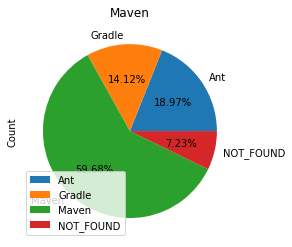

In [12]:
all_errors_df.groupby(['BuildSystem']).sum().plot.pie(y='Count',title="Maven",autopct = "%.2f%%")

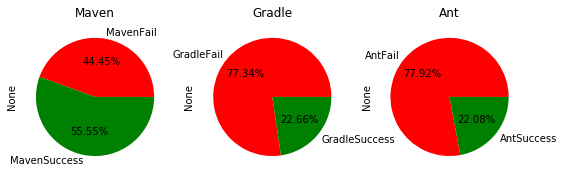

In [13]:
piePlotPerBuildSystem(summary_df)

## 2. Projects Summary - Early Snapshots

In [14]:
early_snapshots_df = pd.DataFrame(early_snapshots)
early_snapshots_df[headers]

,Project,Total,Success,Fail,MavenSuccess,MavenFail,GradleSuccess,GradleFail,AntSuccess,AntFail,NoBuildSystem
0,zxing,881,0,881,0,0,0,0,0,856,25
1,wiremock,456,0,456,0,0,0,0,0,0,456
2,incubator-pinot,1728,1521,207,1521,195,0,0,0,0,12
3,junit4,608,0,608,0,0,0,0,0,601,7
4,httpcomponents-client,779,334,445,334,240,0,0,0,185,20
5,nifi,1446,0,1446,0,402,0,0,0,0,1044
6,powermock,401,104,297,104,297,0,0,0,0,0
7,bookkeeper,564,142,422,142,421,0,0,0,0,1
8,Twitter4J,579,0,579,0,579,0,0,0,0,0
9,spring-data-jpa,351,15,336,15,335,0,0,0,0,1


In [15]:
early_snapshots_df.select_dtypes(pd.np.number).sum()

AntFail           4745
AntSuccess        2445
Fail             18154
GradleFail        1026
GradleSuccess       38
MavenFail         9251
MavenSuccess      8121
NoBuildSystem     3132
Success          10604
Total            28758
dtype: int64

In [16]:
early_errors_df = report(early_snapshots_df["Errors"].sum())
early_errors_df

Count   18,154.00
%          100.00
dtype: float64


,BuildSystem,Error,Action,Count,%
0,Maven,ArtifactResolutionException,Resolution,3593,19.79
1,Maven,Timeout,Resolution,3153,17.37
2,NOT_FOUND,No build system detected,Other,3132,17.25
3,Ant,"Target ""compile"" does not exist in the project",Other,1802,9.93
4,Maven,MojoExecutionException,Other,1682,9.27
5,Ant,Other Ant error,Other,1479,8.15
6,Ant,Compile failed,Compilation,966,5.32
7,Gradle,IOException: Server returned HTTP response cod...,Resolution,644,3.55
8,Maven,MojoFailureException,Other,418,2.30
9,Ant,UnknownHostException,Resolution,385,2.12


In [17]:
early_errors_df.groupby('Action').sum().sort_values(by=['Count'], ascending=False)

,Count,%
Action,,
Other,9310,51.28
Resolution,7780,42.86
Compilation,966,5.32
Parsing,98,0.54


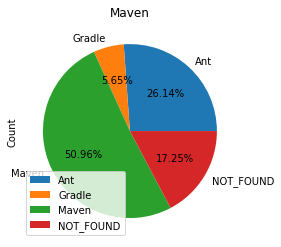

In [18]:
early_errors_df.groupby(['BuildSystem']).sum().plot.pie(y='Count',title="Maven",autopct = "%.2f%%")

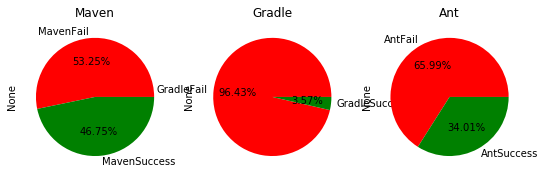

In [19]:
piePlotPerBuildSystem(early_snapshots_df)

## 3. Projects Summary - Intemediate Snapshots

In [20]:
intermediate_snapshots_df = pd.DataFrame(early_snapshots)
intermediate_snapshots_df[headers]

,Project,Total,Success,Fail,MavenSuccess,MavenFail,GradleSuccess,GradleFail,AntSuccess,AntFail,NoBuildSystem
0,zxing,881,0,881,0,0,0,0,0,856,25
1,wiremock,456,0,456,0,0,0,0,0,0,456
2,incubator-pinot,1728,1521,207,1521,195,0,0,0,0,12
3,junit4,608,0,608,0,0,0,0,0,601,7
4,httpcomponents-client,779,334,445,334,240,0,0,0,185,20
5,nifi,1446,0,1446,0,402,0,0,0,0,1044
6,powermock,401,104,297,104,297,0,0,0,0,0
7,bookkeeper,564,142,422,142,421,0,0,0,0,1
8,Twitter4J,579,0,579,0,579,0,0,0,0,0
9,spring-data-jpa,351,15,336,15,335,0,0,0,0,1


In [21]:
intermediate_snapshots_df.select_dtypes(pd.np.number).sum()

AntFail           4745
AntSuccess        2445
Fail             18154
GradleFail        1026
GradleSuccess       38
MavenFail         9251
MavenSuccess      8121
NoBuildSystem     3132
Success          10604
Total            28758
dtype: int64

In [22]:
intermediate_errors_df = report(intermediate_snapshots_df["Errors"].sum())
intermediate_errors_df

Count   18,154.00
%          100.00
dtype: float64


,BuildSystem,Error,Action,Count,%
0,Maven,ArtifactResolutionException,Resolution,3593,19.79
1,Maven,Timeout,Resolution,3153,17.37
2,NOT_FOUND,No build system detected,Other,3132,17.25
3,Ant,"Target ""compile"" does not exist in the project",Other,1802,9.93
4,Maven,MojoExecutionException,Other,1682,9.27
5,Ant,Other Ant error,Other,1479,8.15
6,Ant,Compile failed,Compilation,966,5.32
7,Gradle,IOException: Server returned HTTP response cod...,Resolution,644,3.55
8,Maven,MojoFailureException,Other,418,2.30
9,Ant,UnknownHostException,Resolution,385,2.12


In [23]:
intermediate_errors_df.groupby('Action').sum().sort_values(by=['Count'], ascending=False)

,Count,%
Action,,
Other,9310,51.28
Resolution,7780,42.86
Compilation,966,5.32
Parsing,98,0.54


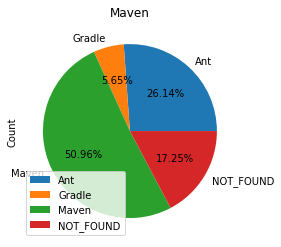

In [24]:
intermediate_errors_df.groupby(['BuildSystem']).sum().plot.pie(y='Count',title="Maven",autopct = "%.2f%%")

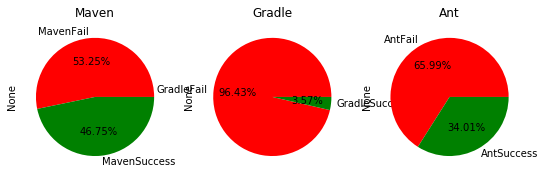

In [25]:
piePlotPerBuildSystem(intermediate_snapshots_df)

## 4. Projects Summary - Recent Snapshots

In [26]:
recent_snapshots_df = pd.DataFrame(recent_snapshots)
recent_snapshots_df[headers]

,Project,Total,Success,Fail,MavenSuccess,MavenFail,GradleSuccess,GradleFail,AntSuccess,AntFail,NoBuildSystem
0,zxing,881,832,49,832,49,0,0,0,0,0
1,wiremock,456,10,446,0,0,10,446,0,0,0
2,incubator-pinot,1728,0,1728,0,1728,0,0,0,0,0
3,junit4,607,605,2,605,2,0,0,0,0,0
4,httpcomponents-client,779,557,222,557,222,0,0,0,0,0
5,nifi,1446,0,1446,0,1446,0,0,0,0,0
6,powermock,401,175,226,165,42,10,184,0,0,0
7,bookkeeper,564,0,564,0,564,0,0,0,0,0
8,Twitter4J,579,495,84,495,84,0,0,0,0,0
9,spring-data-jpa,351,289,62,289,62,0,0,0,0,0


In [27]:
recent_snapshots_df.select_dtypes(pd.np.number).sum()

AntFail           1118
AntSuccess           4
Fail             13262
GradleFail        2676
GradleSuccess     1341
MavenFail         9403
MavenSuccess     14146
NoBuildSystem       65
Success          15491
Total            28753
dtype: int64

In [28]:
recent_errors_df = report(recent_snapshots_df["Errors"].sum())
recent_errors_df

Count   13,262.00
%          100.00
dtype: float64


,BuildSystem,Error,Action,Count,%
0,Maven,ArtifactResolutionException,Resolution,3036,22.89
1,Maven,MojoExecutionException,Other,2308,17.40
2,Maven,Timeout,Resolution,2247,16.94
3,Gradle,Other Gradle error,Other,1278,9.64
4,Ant,UnknownHostException,Resolution,919,6.93
5,Maven,PluginDescriptorParsingException,Parsing,418,3.15
6,Maven,PluginResolutionException,Resolution,409,3.08
7,Gradle,Could not resolve all dependencies,Resolution,368,2.77
8,Gradle,Unable to retrieve secret key,Other,318,2.40
9,Maven,MojoFailureException,Other,311,2.35


In [29]:
recent_errors_df.groupby('Action').sum().sort_values(by=['Count'], ascending=False)

,Count,%
Action,,
Resolution,7572,57.10
Other,5217,39.34
Parsing,456,3.44
Compilation,17,0.13


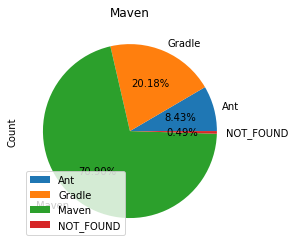

In [30]:
recent_errors_df.groupby(['BuildSystem']).sum().plot.pie(y='Count',title="Maven",autopct = "%.2f%%")

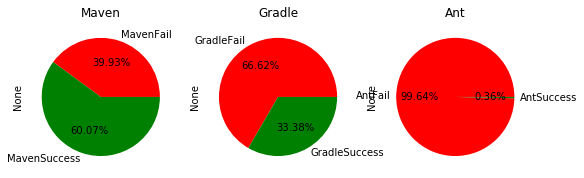

In [31]:
piePlotPerBuildSystem(recent_snapshots_df)

## 5. Errors per Build System

In [32]:
maven_errors  = []
ant_errors    = []
gradle_errors = []

maven_errors_complete  = []
ant_errors_complete    = []
gradle_errors_complete = []

for project in all_projects_summary:
    for error in project['Errors']:
        build_system = error[0]
        trace        = error[1]
        category     = error[2]
        if build_system == 'Maven':
            maven_errors.append(category)
            maven_errors_complete.append((trace, category))
        if build_system == 'Ant':
            ant_errors.append(category)
            ant_errors_complete.append((trace, category))
        if build_system == 'Gradle':
            gradle_errors.append(category)
            gradle_errors_complete.append((trace, category))

In [33]:
from collections import Counter

all_errors = maven_errors + ant_errors + gradle_errors

for build_system, errors in [("Maven",maven_errors), ("Ant",ant_errors), ("Gradle",gradle_errors), ("All", all_errors)]:
    counter = Counter(errors)
    print(build_system)
    print("   Resolution       {:.0f}".format(int(counter['Resolution'])))
    print("   Resolution (%)   {:.2f}".format(int(counter['Resolution'])*100/len(errors)))
    print("   Parsing          {:.0f}".format(int(counter['Parsing'])))
    print("   Parsing (%)      {:.2f}".format(int(counter['Parsing'])*100/len(errors)))
    print("   Compilation      {:.0f}".format(int(counter['Compilation'])))
    print("   Compilation (%)  {:.2f}".format(int(counter['Compilation'])*100/len(errors)))
    print("   Other            {:.0f}".format(int(counter['Other'])))
    print("   Other (%)        {:.2f}".format(int(counter['Other'])*100/len(errors)))

Maven
   Resolution       25150
   Resolution (%)   67.39
   Parsing          970
   Parsing (%)      2.60
   Compilation      0
   Compilation (%)  0.00
   Other            11200
   Other (%)        30.01
Ant
   Resolution       3151
   Resolution (%)   26.56
   Parsing          0
   Parsing (%)      0.00
   Compilation      980
   Compilation (%)  8.26
   Other            7734
   Other (%)        65.18
Gradle
   Resolution       4370
   Resolution (%)   49.50
   Parsing          0
   Parsing (%)      0.00
   Compilation      268
   Compilation (%)  3.04
   Other            4191
   Other (%)        47.47
All
   Resolution       32671
   Resolution (%)   56.32
   Parsing          970
   Parsing (%)      1.67
   Compilation      1248
   Compilation (%)  2.15
   Other            23125
   Other (%)        39.86
